## COVID-19 
### All countries (Johns Hopkins)
#### Data source: https://github.com/CSSEGISandData/COVID-19

In [78]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import re
import json
import folium
import difflib
%matplotlib inline
#plt.style.use('fivethirtyeight')
sns.set()

##### gathering data from https://github.com/CSSEGISandData/COVID-19

In [79]:
df_confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_deaths_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_recovered_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

df_confirmed = df_confirmed_raw.melt(id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='date', value_name='cnt')\
    .assign(date=lambda x: pd.to_datetime(x.date))\
    .assign(type='confirmed')

df_deaths = df_deaths_raw.melt(id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='date', value_name='cnt')\
    .assign(date=lambda x: pd.to_datetime(x.date))\
    .assign(type='deaths')

df_recovered = df_recovered_raw.melt(id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='date', value_name='cnt') \
    .assign(date=lambda x : pd.to_datetime(x['date'])) \
    .assign(type="recovered")

df_covid19 = pd.concat([df_confirmed, df_deaths, df_recovered]).reset_index(drop=True)
df_covid19

,Province/State,Country/Region,Lat,Long,date,cnt,type
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,confirmed
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,confirmed
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,confirmed
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,confirmed
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,confirmed
...,...,...,...,...,...,...,...
70273,NaN,Saint Lucia,13.9094,-60.9789,2020-03-14,0,recovered
70274,NaN,Saint Vincent and the Grenadines,12.9843,-61.2872,2020-03-14,0,recovered
70275,NaN,Suriname,3.9193,-56.0278,2020-03-14,0,recovered
70276,"Virgin Islands, U.S.",US,18.3358,-64.8963,2020-03-14,0,recovered


get country codes from https://countrycode.org 

In [80]:
# get country codes
url_codes = "https://countrycode.org/"
codes_html = requests.get(url_codes).text
soup = BeautifulSoup(codes_html, 'html.parser')
code_table = soup.find('table', {'data-sort-name':'countrycode'})
df_cc = pd.read_html(str(code_table))[0]
df_cc[['ISO2', 'ISO3']] = df_cc['ISO CODES'].str.split(' / ', expand=True)
df_cc

,COUNTRY,COUNTRY CODE,ISO CODES,POPULATION,AREA KM2,GDP $USD,ISO2,ISO3
0,Afghanistan,93,AF / AFG,29121286,647500,20.65 Billion,AF,AFG
1,Albania,355,AL / ALB,2986952,28748,12.8 Billion,AL,ALB
2,Algeria,213,DZ / DZA,34586184,2381740,215.7 Billion,DZ,DZA
3,American Samoa,1-684,AS / ASM,57881,199,462.2 Million,AS,ASM
4,Andorra,376,AD / AND,84000,468,4.8 Billion,AD,AND
...,...,...,...,...,...,...,...,...
235,Wallis and Futuna,681,WF / WLF,16025,274,NaN,WF,WLF
236,Western Sahara,212,EH / ESH,273008,266000,NaN,EH,ESH
237,Yemen,967,YE / YEM,23495361,527970,43.89 Billion,YE,YEM
238,Zambia,260,ZM / ZMB,13460305,752614,22.24 Billion,ZM,ZMB


In [81]:
#mapping iso codes:
df_covid19['country_key'] =df_covid19['Country/Region']
countries_cc = df_cc['COUNTRY']
df_covid19[~df_covid19['country_key'].isin(countries_cc)]['country_key'].drop_duplicates()


38                    North Macedonia
87                      French Guiana
89                         Martinique
100                                US
136                          Holy See
158                      Korea, South
167                       Cruise Ship
188                           Czechia
192                           Taiwan*
205                  Congo (Kinshasa)
206                     Cote d'Ivoire
410                        Guadeloupe
431                          Eswatini
441    occupied Palestinian territory
Name: country_key, dtype: object

In [82]:
df_covid19['country_key'] = df_covid19['country_key'].replace({'Mainland China':'China', 'US':'United States', 'UK':'United Kingdom', 'North Macedonia':'Macedonia', 'Others':np.nan})
df_covid19[~df_covid19['country_key'].isin(countries_cc)]['country_key'].drop_duplicates()

87                      French Guiana
89                         Martinique
136                          Holy See
158                      Korea, South
167                       Cruise Ship
188                           Czechia
192                           Taiwan*
205                  Congo (Kinshasa)
206                     Cote d'Ivoire
410                        Guadeloupe
431                          Eswatini
441    occupied Palestinian territory
Name: country_key, dtype: object

#### merge the data:

In [83]:
df_covid19 = df_covid19.merge(df_cc, left_on='country_key', right_on='COUNTRY')

In [84]:
df_covid19

,Province/State,Country/Region,Lat,Long,date,cnt,type,country_key,COUNTRY,COUNTRY CODE,ISO CODES,POPULATION,AREA KM2,GDP $USD,ISO2,ISO3
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,confirmed,Thailand,Thailand,66,TH / THA,67089500,514000,400.9 Billion,TH,THA
1,NaN,Thailand,15.0000,101.0000,2020-01-23,3,confirmed,Thailand,Thailand,66,TH / THA,67089500,514000,400.9 Billion,TH,THA
2,NaN,Thailand,15.0000,101.0000,2020-01-24,5,confirmed,Thailand,Thailand,66,TH / THA,67089500,514000,400.9 Billion,TH,THA
3,NaN,Thailand,15.0000,101.0000,2020-01-25,7,confirmed,Thailand,Thailand,66,TH / THA,67089500,514000,400.9 Billion,TH,THA
4,NaN,Thailand,15.0000,101.0000,2020-01-26,8,confirmed,Thailand,Thailand,66,TH / THA,67089500,514000,400.9 Billion,TH,THA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68365,NaN,Suriname,3.9193,-56.0278,2020-03-10,0,recovered,Suriname,Suriname,597,SR / SUR,492829,163270,5.009 Billion,SR,SUR
68366,NaN,Suriname,3.9193,-56.0278,2020-03-11,0,recovered,Suriname,Suriname,597,SR / SUR,492829,163270,5.009 Billion,SR,SUR
68367,NaN,Suriname,3.9193,-56.0278,2020-03-12,0,recovered,Suriname,Suriname,597,SR / SUR,492829,163270,5.009 Billion,SR,SUR
68368,NaN,Suriname,3.9193,-56.0278,2020-03-13,0,recovered,Suriname,Suriname,597,SR / SUR,492829,163270,5.009 Billion,SR,SUR


### create main pivot for a major part of the analysis:

In [85]:
df_covid_19_pivot = df_covid19.pivot_table(index=['Country/Region','ISO3', 'date'], columns='type', values='cnt', aggfunc='sum').assign(sick=lambda x: x['confirmed'] - x['deaths'] - x['recovered']).reset_index()
df_covid_19_pivot

type,Country/Region,ISO3,date,confirmed,deaths,recovered,sick
0,Afghanistan,AFG,2020-01-22,0,0,0,0
1,Afghanistan,AFG,2020-01-23,0,0,0,0
2,Afghanistan,AFG,2020-01-24,0,0,0,0
3,Afghanistan,AFG,2020-01-25,0,0,0,0
4,Afghanistan,AFG,2020-01-26,0,0,0,0
...,...,...,...,...,...,...,...
6938,Vietnam,VNM,2020-03-10,31,0,16,15
6939,Vietnam,VNM,2020-03-11,38,0,16,22
6940,Vietnam,VNM,2020-03-12,39,0,16,23
6941,Vietnam,VNM,2020-03-13,47,0,16,31


#### create overall data frame for all countries

In [86]:
df_world = df_covid_19_pivot.groupby('date').agg({'confirmed':'sum', 'deaths':'sum', 'recovered':'sum', 'sick':'sum'}).reset_index()
df_world

,date,confirmed,deaths,recovered,sick
0,2020-01-22,553,17,28,508
1,2020-01-23,651,18,30,603
2,2020-01-24,936,26,36,874
3,2020-01-25,1429,42,39,1348
4,2020-01-26,2111,56,52,2003
5,2020-01-27,2918,82,61,2775
6,2020-01-28,5566,131,107,5328
7,2020-01-29,6154,133,126,5895
8,2020-01-30,8221,171,143,7907
9,2020-01-31,9906,213,222,9471


Text(0.5, 1.0, 'World')

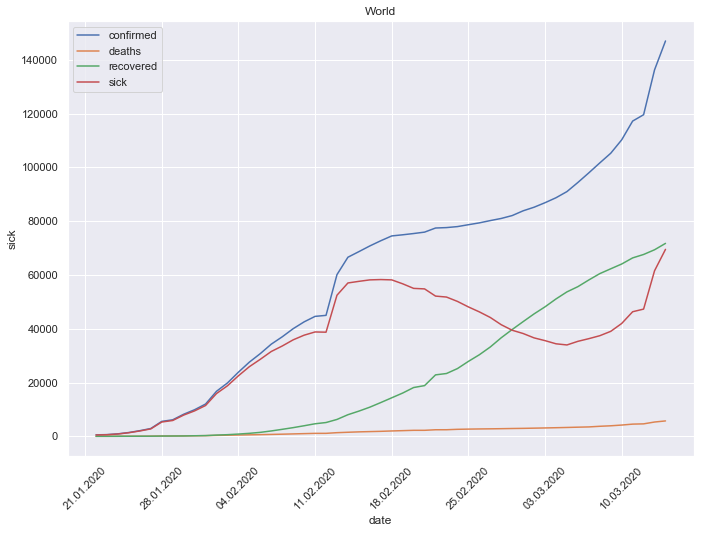

In [87]:
fig = plt.figure(figsize=(10,8))
for ctype in ['confirmed', 'deaths', 'recovered', 'sick']:
    ax = sns.lineplot(y=ctype, x='date', data=df_world, label = ctype)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#m = mdates.WeekdayLocator()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('World')

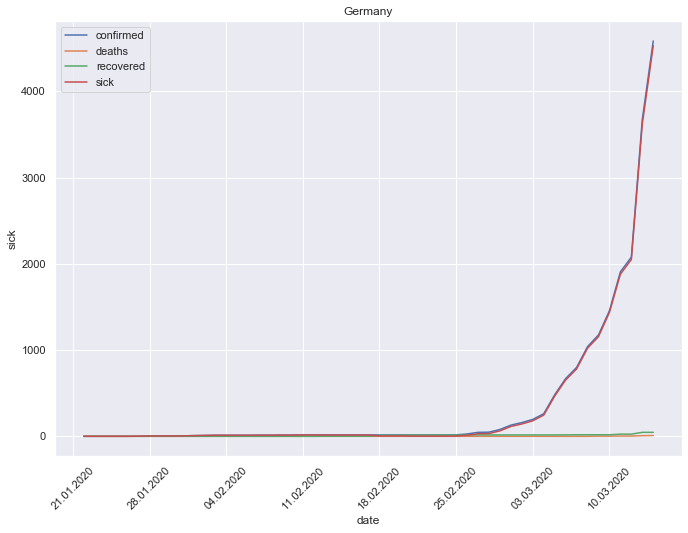

In [88]:
def plot_country(countrycode):
    fig = plt.figure(figsize=(10,8))
    for ctype in ['confirmed', 'deaths', 'recovered', 'sick']:
        ax = sns.lineplot(y=ctype, x='date', data=df_covid_19_pivot[df_covid_19_pivot['ISO3']==countrycode], label = ctype)
    ax.set_title(df_covid_19_pivot[df_covid_19_pivot['ISO3']==countrycode]['Country/Region'].head(1).values[0])
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #m = mdates.WeekdayLocator()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    ax.xaxis.set_tick_params(rotation=45)
plot_country("DEU")


### calculate `X` countries with most confirmed cases:

In [91]:
X = 20
top = list(df_covid_19_pivot.groupby('ISO3').confirmed.sum().nlargest(X).index)
df_top = df_covid_19_pivot[df_covid_19_pivot['ISO3'].isin(top)].reset_index().drop('index', axis=1)

##### calculate column with difference to previous day:

In [92]:
df_top['confirmed_diff'] = df_top.groupby('ISO3').confirmed.diff()
df_top

type,Country/Region,ISO3,date,confirmed,deaths,recovered,sick,confirmed_diff
0,Australia,AUS,2020-01-22,0,0,0,0,NaN
1,Australia,AUS,2020-01-23,0,0,0,0,0.0
2,Australia,AUS,2020-01-24,0,0,0,0,0.0
3,Australia,AUS,2020-01-25,0,0,0,0,0.0
4,Australia,AUS,2020-01-26,4,0,0,4,4.0
...,...,...,...,...,...,...,...,...
1055,United Kingdom,GBR,2020-03-10,384,6,19,359,62.0
1056,United Kingdom,GBR,2020-03-11,459,8,19,432,75.0
1057,United Kingdom,GBR,2020-03-12,459,8,19,432,0.0
1058,United Kingdom,GBR,2020-03-13,801,8,19,774,342.0


### Plot a facet grid with top X countries:

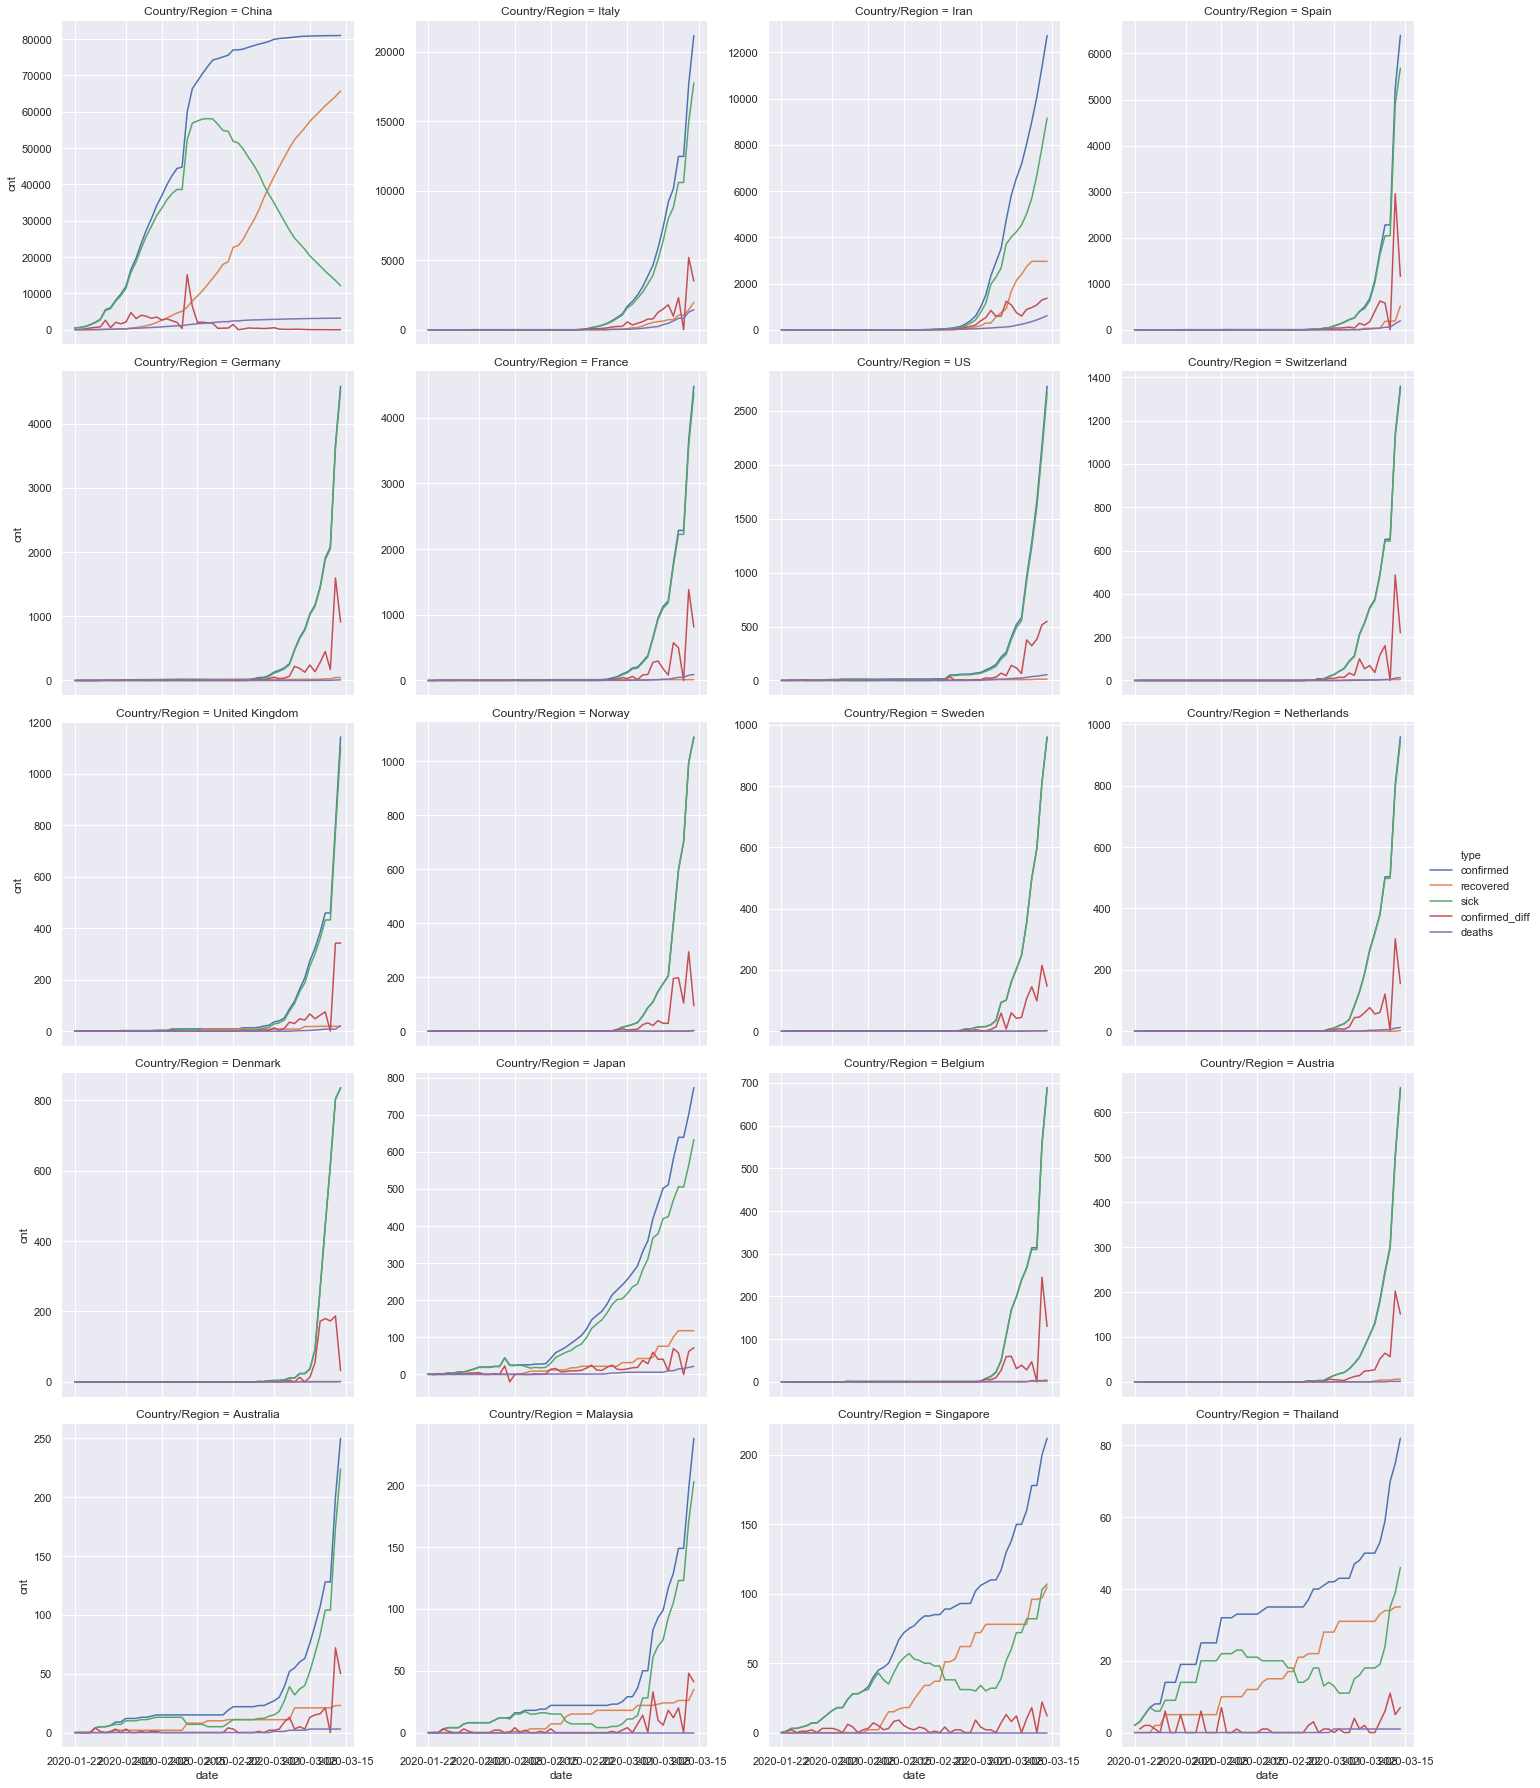

In [93]:
sns.relplot(data=df_top.melt(id_vars=['Country/Region', 'ISO3', 'date'], value_name='cnt').sort_values(by='cnt', ascending=False), kind='line', x='date', y='cnt', hue='type', col='Country/Region', col_wrap=4, facet_kws={'sharey':False})

In [90]:
plt.figure(figsize=(15,5))
data = df_top[df_top.date > '20/02/2020']
ax=sns.lineplot(data=data, x='date',y='confirmed_diff', hue='ISO3', style=True)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_tick_params(rotation=45)

ValueError: Could not interpret input 'confirmed_diff'

<Figure size 1080x360 with 0 Axes>

In [65]:
country_geo = './data/custom.geo.json'
df_chloro = df_covid_19_pivot[df_covid_19_pivot['date']=='29/02/2020'].assign(confirmed_log = lambda x: np.log10(x['confirmed'])).replace({-np.inf:np.nan})
m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB dark_matter')

choropleth = folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=df_chloro,
    columns=['ISO3', 'confirmed_log'],
    key_on='feature.properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.7,
    nan_fill_opacity=0,
    line_opacity=0.8,
    legend_name='Confirmed cases (log)'
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['pop_est'])
)

folium.LayerControl().add_to(m)

m

C:\Users\norma\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:

df_covid_19_pivot.groupby([df_covid_19_pivot.date.dt.week, 'Country/Region']).agg({'confirmed':'sum', 'deaths':'sum', 'recovered':'sum', 'sick':'sum'})

confirmed  deaths  recovered  sick
date Country/Region                                          
4    Afghanistan                   0       0          0     0
     Albania                       0       0          0     0
     Algeria                       0       0          0     0
     Andorra                       0       0          0     0
     Antigua and Barbuda           0       0          0     0
...                              ...     ...        ...   ...
11   United Arab Emirates        448       0         87   361
     United Kingdom             3568      55        113  3400
     Uruguay                       4       0          0     4
     Venezuela                     2       0          0     2
     Vietnam                     238       0         96   142

[1048 rows x 4 columns]

In [67]:
df_countries_date = df_covid_19_pivot.groupby(['date', 'Country/Region']).filter(lambda x: x['confirmed'] > 0)

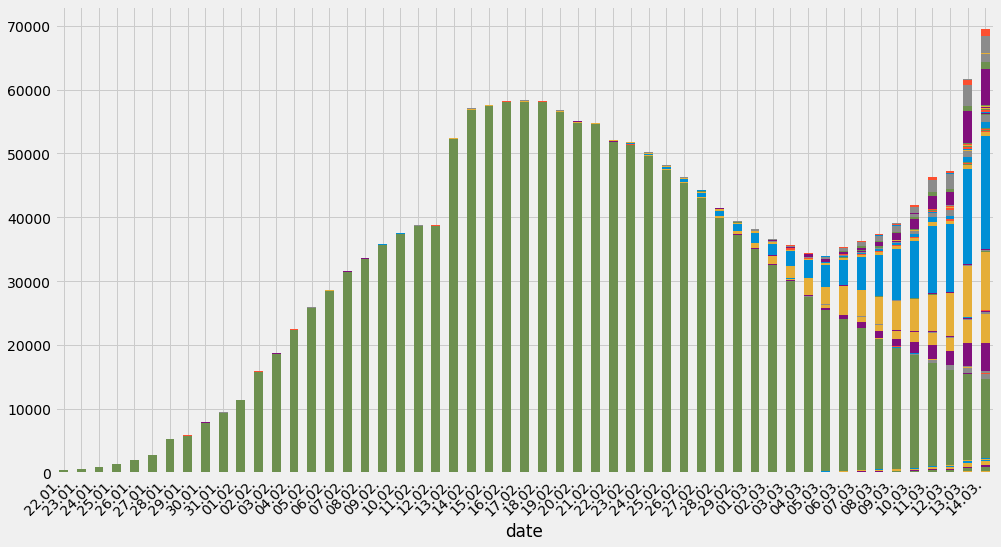

In [68]:
plot_data = df_countries_date.pivot_table(index='date', columns='Country/Region', values='sick', aggfunc='sum')
ax = plot_data.plot(kind='bar', stacked=True, figsize=(15,8))
ax.get_legend().remove()
xdates = plot_data.index.strftime('%d.%m.')
_ = ax.set_xticklabels(xdates,rotation=45, ha='right')

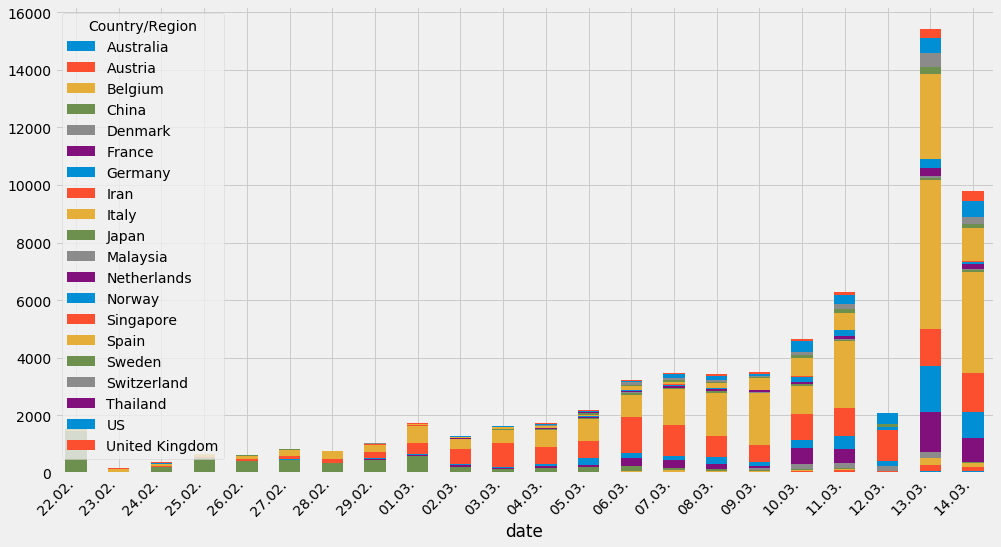

In [69]:
plot_data = df_top.pivot_table(index='date', columns='Country/Region', values='confirmed_diff', aggfunc='sum').loc['22.02.2020':]
ax = plot_data.plot(kind='bar', stacked=True, figsize=(15,8))
xdates = plot_data.index.strftime('%d.%m.')
_ = ax.set_xticklabels(xdates,rotation=45, ha='right')

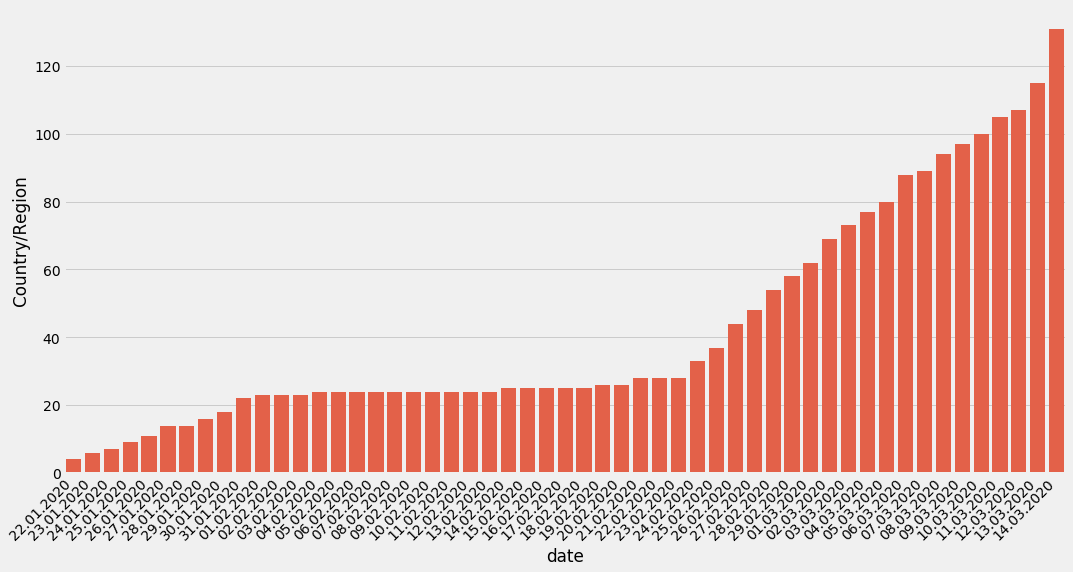

In [70]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = sns.barplot(data=df_countries_date.groupby('date')['Country/Region'].nunique().reset_index(), y='Country/Region', x='date', color="C1")
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gcf().autofmt_xdate()
ax.set_xticklabels([pandas_datetime.strftime("%d.%m.%Y") for pandas_datetime in df_countries_date.groupby('date')['Country/Region'].nunique().reset_index()['date']])

_ = ax.set_xticklabels(labels= ax.get_xticklabels(),rotation = 45, ha='right')

In [71]:
df_countries_date

type,Country/Region,ISO3,date,confirmed,deaths,recovered,sick
33,Afghanistan,AFG,2020-02-24,1,0,0,1
34,Afghanistan,AFG,2020-02-25,1,0,0,1
35,Afghanistan,AFG,2020-02-26,1,0,0,1
36,Afghanistan,AFG,2020-02-27,1,0,0,1
37,Afghanistan,AFG,2020-02-28,1,0,0,1
...,...,...,...,...,...,...,...
6938,Vietnam,VNM,2020-03-10,31,0,16,15
6939,Vietnam,VNM,2020-03-11,38,0,16,22
6940,Vietnam,VNM,2020-03-12,39,0,16,23
6941,Vietnam,VNM,2020-03-13,47,0,16,31


In [72]:
df_covid_19_pivot.groupby('Country/Region')

In [73]:
df_covid_19_pivot['ISO3']

0       AFG
1       AFG
2       AFG
3       AFG
4       AFG
       ... 
6938    VNM
6939    VNM
6940    VNM
6941    VNM
6942    VNM
Name: ISO3, Length: 6943, dtype: object

In [74]:
df_covid_19_pivot['confirmed_diff'] = df_covid_19_pivot.groupby('ISO3').confirmed.diff()

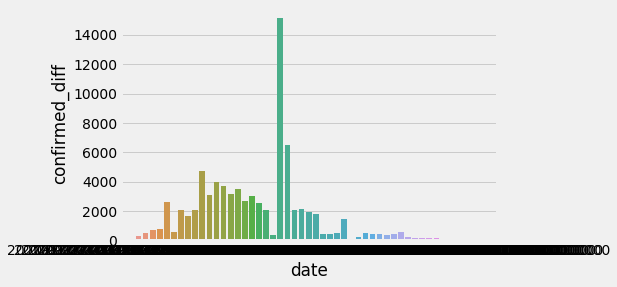

In [75]:
sns.barplot(data= df_covid_19_pivot[df_covid_19_pivot['ISO3']=='CHN'], x='date', y='confirmed_diff')

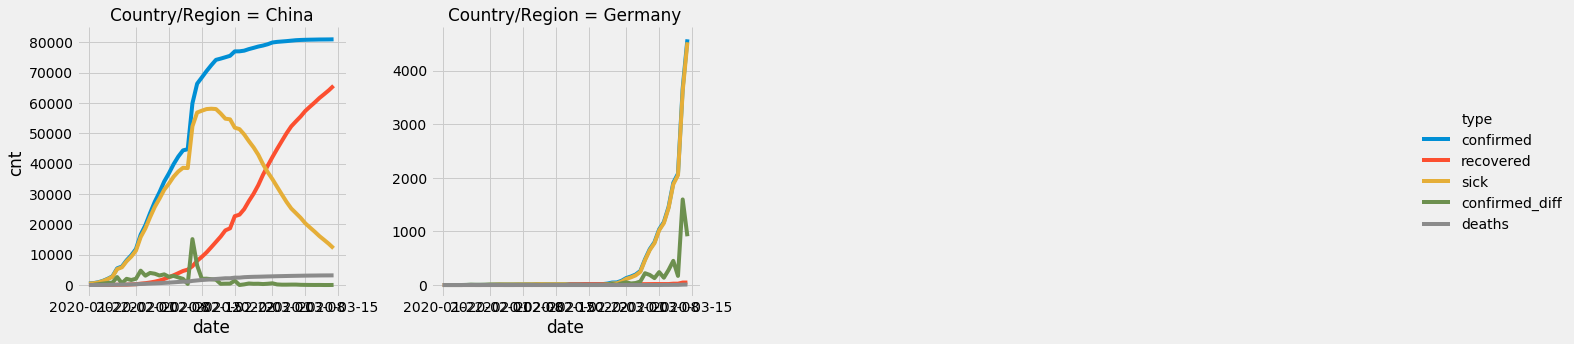

In [76]:
sns.relplot(data=df_covid_19_pivot[df_covid_19_pivot['ISO3'].isin(['CHN', 'DEU'])].melt(id_vars=['Country/Region', 'ISO3', 'date'], value_name='cnt').sort_values(by='cnt', ascending=False), kind='line', x='date', y='cnt', hue='type', col='Country/Region', col_wrap=4, facet_kws={'sharey':False})

In [77]:
df_covid_19_pivot['confirmed_diff'] = df_covid_19_pivot.groupby('ISO3').confirmed.diff()


In [ ]:
for i in range(1,5):
    print(df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-i))].nlargest(10, 'confirmed_diff')[['Country/Region', 'confirmed_diff']])

In [ ]:
date.today() - timedelta(days=1)

In [ ]:
print(df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-1))].sort_values( by='confirmed', ascending=False)[['Country/Region', 'confirmed']])

In [ ]:
df = df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-1))].sort_values( by='deaths', ascending=False)[['Country/Region', 'deaths', 'confirmed']]
df['calc_confirmed'] = df['deaths'] / 0.01
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

In [ ]:
rki = pd.read_csv('./data/rkicsv.csv')

In [ ]:
df_rki = pd.read_html('https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html;jsessionid=9872726E3BB3EC812BDEB5078D49182E.internet071')[0]

In [16]:
df_rki.to_csv('./data/rki_germany_09022020.csv')

NameError: name 'df_rki' is not defined

In [17]:
df_c = df_covid_19_pivot.copy()

In [18]:
df_c[df_c['ISO3']=='ITA'].set_index('date').resample('1D').confirmed_diff.sum()

AttributeError: 'DatetimeIndexResampler' object has no attribute 'confirmed_diff'

array([737476., 737480., 737484., 737485., 737489., 737493., 737497.])

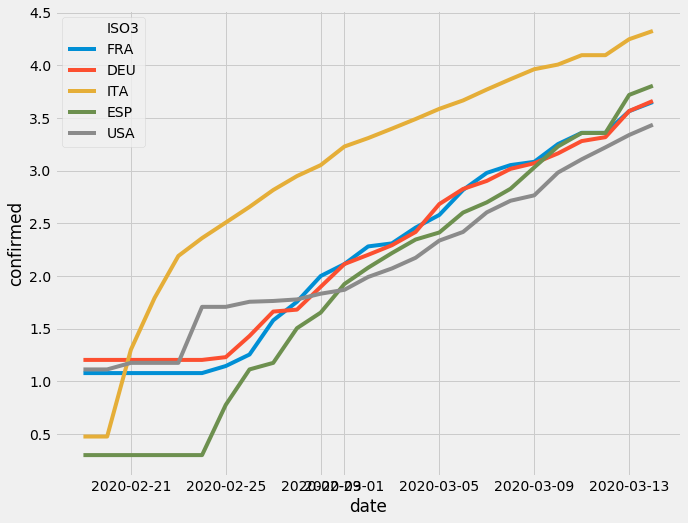

In [22]:
data = df_c[df_c['ISO3'].isin(['DEU','USA','FRA', 'ITA','ESP'])].set_index('date').loc['02/19/2020':'03/14/2020']
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=data, x= data.index, y=np.log10(data.confirmed), hue='ISO3')
xdates = ax.get_xticks()
#_ = ax.set_xticklabels(xdates,rotation=45, ha='right')
[pd.to_datetime(d).strftime('%d.%m') for d in xdates]
xdates

In [24]:
data = df_c.groupby(['ISO3', 'date']).filter(lambda x: x['confirmed']>=50)
data['no_days'] = data.groupby(['ISO3']).date.rank("dense")

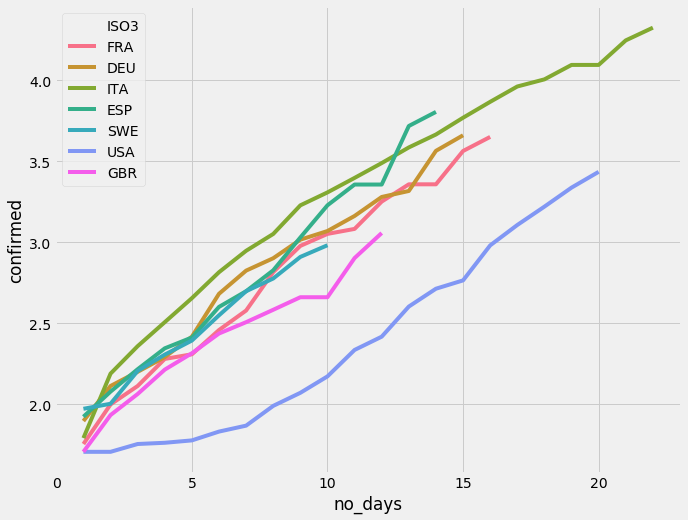

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_data=data[data['ISO3'].isin(['DEU','ITA','FRA','USA', 'ESP', 'GBR', 'SWE'])]
sns.lineplot(data=plot_data, x='no_days', y=(np.log10(plot_data.confirmed)), hue='ISO3')